In [1]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

from neurodsp.sim import sim_bursty_oscillation, sim_oscillation
from neurodsp.spectral import compute_spectrum

from timescales.sim import sim_spikes_synaptic, exp_decay_func, sim_acf_cos
from timescales.est import compute_acf, fit_acf, fit_acf_cos, fit_psd, convert_knee_val

## Manuscript Figures

### Figure 1

Timscale Methods & Applications

- Traditional ACF approach
    - Avg. ACF of population
- Related Errors
    - Bias (Bayes paper) <- need to implement
        - ~~Limits event-related application~~
        - Multiple Trials (ACF vs Spectral)
    - Oscillations
        - SpecParam
        - ACF + Cos
        
Below, each trace is a separate neuron (equivalent to a separate trial). 100 neurons/trials are simulated, each with 2s of signal, simulating an event-related design.

In [2]:
# Settings
n_seconds = 2
fs = 1000
tau = 0.025
var_noise = None
n_trials = 100 # could also be interpreted as independent neurons

# Simulate Spikes
spikes = np.zeros((n_trials, int(n_seconds * fs)))
spikes_osc = np.zeros((n_trials, int(n_seconds * fs)))

for i in range(n_trials):
    
    _probs, _spikes = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=1,
                                          mu=10, var_noise=var_noise, return_sum=False)
    
    spikes[i] = _probs
    
    # Add oscillation
    _cos = sim_oscillation(n_seconds, fs, 10, phase='max')
    _cos -= _cos.min()
    _cos /= _cos.max()
    
    spikes_osc[i] = _probs + (_cos * .25)
    spikes_osc[i] = spikes_osc[i] / np.max(spikes_osc[i])
    
# Compute ACF
corrs = compute_acf(spikes, 500)
params_acf = fit_acf(corrs, fs)
params_acf_mean = fit_acf(corrs.mean(axis=0), fs)

corrs_osc = compute_acf(spikes_osc, 500)
params_acf_osc = fit_acf_cos(corrs_osc, fs)
params_acf_mean_osc = fit_acf_cos(corrs_osc.mean(axis=0), fs)

# Fit Spectra
f_range = (1, 100)
fooof_init = {'max_n_peaks': 0}
freqs, powers = compute_spectrum(spikes, fs)
fg, knee_freq, knee_tau = fit_psd(freqs, powers, f_range, fooof_init)
fg_mean, knee_freq_mean, knee_tau_mean = fit_psd(freqs, powers, f_range, fooof_init, mode='mean')

fooof_init = {'max_n_peaks': 1}
freqs_osc, powers_osc = compute_spectrum(spikes_osc, fs)
fg_osc, knee_freq_osc, knee_tau_osc = fit_psd(freqs_osc, powers_osc, f_range, fooof_init)
fg_mean_osc, knee_freq_mean_osc, knee_tau_mean_osc = fit_psd(freqs_osc, powers_osc, f_range, fooof_init, mode='mean')

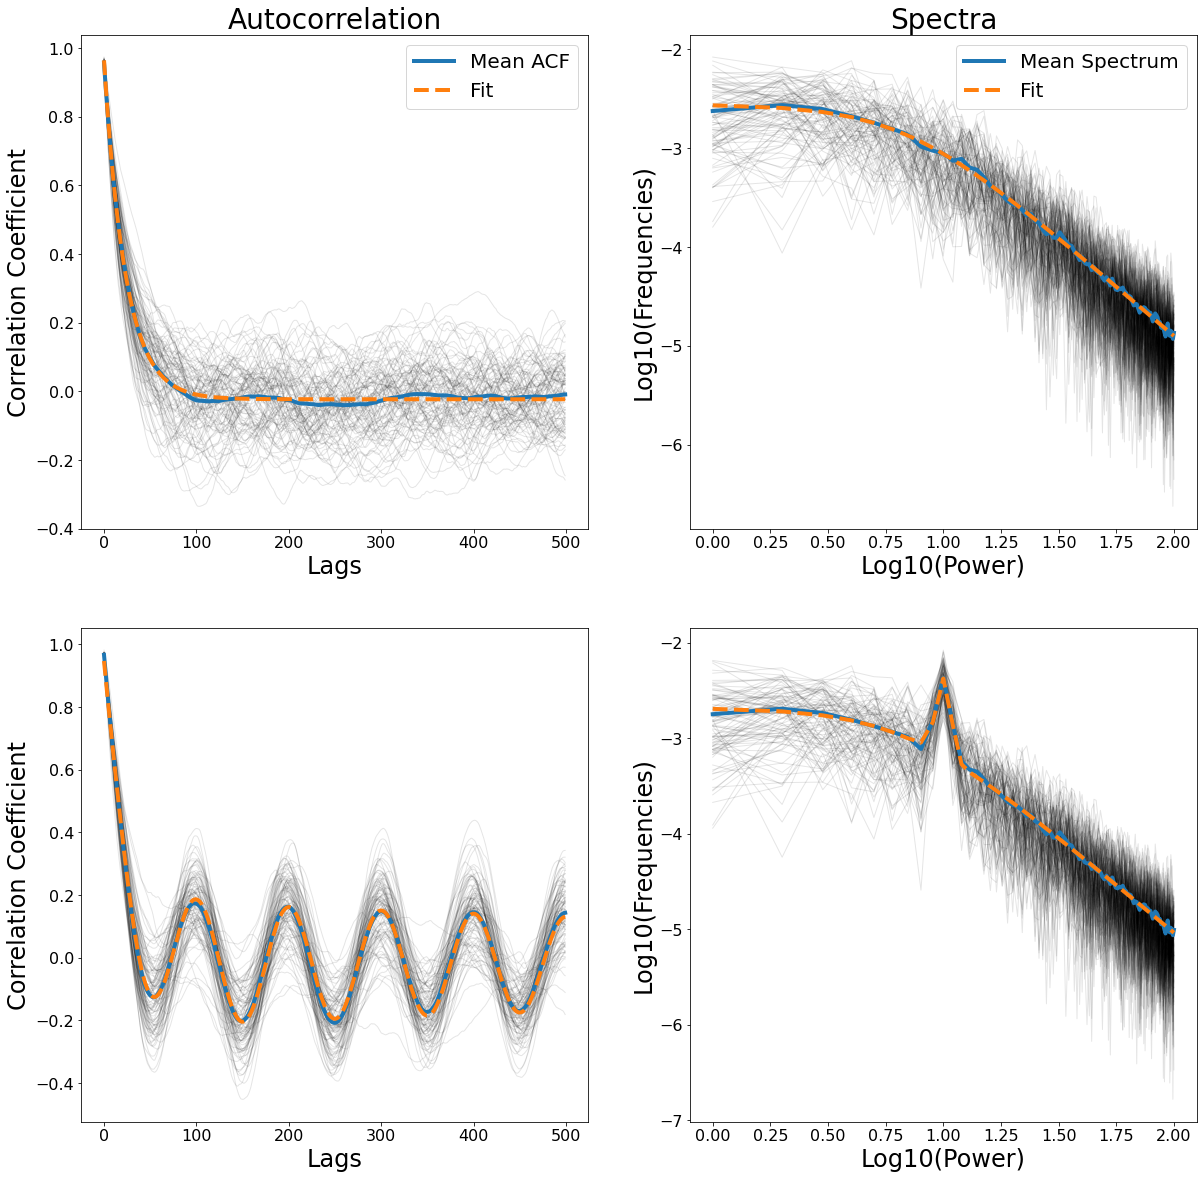

In [3]:
# Plot ACF
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))

for ind, c in enumerate(corrs):
    axes[0][0].plot(c, color='k', alpha=.1, lw=1)
for ind, c in enumerate(corrs_osc):
    axes[1][0].plot(c, color='k', alpha=.1, lw=1)
    
axes[0][0].plot(corrs.mean(axis=0), label=f'Mean ACF', lw=4)
axes[1][0].plot(corrs_osc.mean(axis=0), label=f'Mean ACF', lw=4)


axes[0][0].set_xlabel('Lags', fontsize=24)
axes[1][0].set_xlabel('Lags', fontsize=24)
axes[0][0].set_ylabel('Correlation Coefficient', fontsize=24)
axes[1][0].set_ylabel('Correlation Coefficient', fontsize=24)
     
axes[0][0].tick_params(axis='x', labelsize=16)
axes[0][1].tick_params(axis='x', labelsize=16)
axes[1][0].tick_params(axis='x', labelsize=16)
axes[1][1].tick_params(axis='x', labelsize=16)
axes[0][0].tick_params(axis='y', labelsize=16)
axes[0][1].tick_params(axis='y', labelsize=16)
axes[1][0].tick_params(axis='y', labelsize=16)
axes[1][1].tick_params(axis='y', labelsize=16)

# Plot Spectra
for p in fg.power_spectra:
    axes[0][1].plot(np.log10(fg.freqs), p, color='k', alpha=.1, lw=1)
    
for p in fg_osc.power_spectra:
    axes[1][1].plot(np.log10(fg_osc.freqs), p, color='k', alpha=.1, lw=1)
    
axes[0][1].plot(np.log10(fg.freqs), np.log10(np.mean(10**fg.power_spectra, axis=0)),
                lw=4, color='C0', label='Mean Spectrum')
axes[0][1].set_xlabel('Log10(Power)', fontsize=24)
axes[0][1].set_ylabel('Log10(Frequencies)', fontsize=24)


axes[1][1].plot(np.log10(fg_osc.freqs), np.log10(np.mean(10**fg_osc.power_spectra, axis=0)),
                lw=4, color='C0', label='Mean Spectrum')
axes[1][1].set_xlabel('Log10(Power)', fontsize=24)
axes[1][1].set_ylabel('Log10(Frequencies)', fontsize=24);

axes[0][0].set_title('Autocorrelation', fontsize=28)
axes[0][1].set_title('Spectra', fontsize=28);

# Plt fits
acf_fit = exp_decay_func(np.arange(1, len(corrs[0])+1), fs, *params_acf_mean)
acf_cos_fit = sim_acf_cos(np.arange(1, len(corrs[0])+1), fs, *params_acf_mean_osc)

axes[0][0].plot(acf_fit, label='Fit', color='C1', lw=4, ls='--')
axes[0][1].plot(np.log10(fg_mean.freqs), fg_mean.fooofed_spectrum_, label='Fit', color='C1', lw=4, ls='--')
axes[1][0].plot(acf_cos_fit, color='C1', lw=4, ls='--')
axes[1][1].plot(np.log10(fg_mean_osc.freqs), fg_mean_osc.fooofed_spectrum_, color='C1', lw=4, ls='--')


axes[0][0].legend(fontsize=20, loc='upper right')
axes[0][1].legend(fontsize=20, loc='upper right');
plt.savefig('fig1.png')

### Figure 2

Ground Truth Simulations

- Explain the Convolution + Sampling Method
- Show that methods recapitulate ground truth

In [4]:
from neurodsp.sim import sim_synaptic_kernel

n_seconds = 2
fs = 1000
kernel = sim_synaptic_kernel(5 * tau, fs, 0, tau)
mu = 50

# Pad n_seconds to account for convolution
kern_len = len(kernel[0]) if kernel.ndim == 2 else len(kernel)
times = np.arange(0, int(n_seconds + (kern_len * 2)), 1/fs)

# Randomly sample isi's
isi = np.round_(np.random.exponential(scale=mu, size=len(times))).astype(int)

n_samples = int(n_seconds * fs)
last_ind = np.where(isi.cumsum() >= n_samples)[0]
inds = isi.cumsum() if len(last_ind) == 0 else isi[:last_ind[0]].cumsum()

poisson = np.zeros(len(times), dtype=bool)
poisson[inds] = True

# Convolve the binary poisson array with the kernel
probs = np.convolve(poisson, kernel)[:n_samples]
probs = (probs - np.min(probs)) / np.ptp(probs)

n_neurons = 1
spikes = np.zeros((n_neurons, len(probs)), dtype=bool)
for ind in range(n_neurons):
    spikes[ind] = (probs > np.random.rand(*probs.shape))
    
times = times[:n_samples]
spikes = spikes[0, :n_samples]
poisson = poisson[:n_samples]

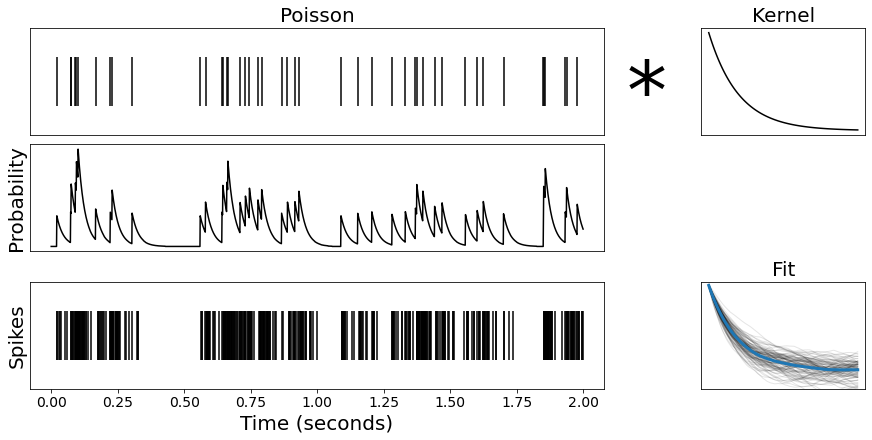

In [5]:
fig = plt.figure(constrained_layout=True, figsize=(12, 6))
gs = fig.add_gridspec(3, 10)

ax0 = fig.add_subplot(gs[0, :7])
ax1 = fig.add_subplot(gs[0, 7:8])
ax2 = fig.add_subplot(gs[0, 8:])
ax3 = fig.add_subplot(gs[1, :7], sharex=ax0)
ax4 = fig.add_subplot(gs[2, :7], sharex=ax0)
ax5 = fig.add_subplot(gs[2, 8:])

ax0.eventplot(times[poisson], color='k')
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax0.set_title('Poisson', size=20)
ax0.set_xlim(times[poisson][0]-.1, times[poisson][-1]+.1)

ax1.text(.2, 0.15, '*', fontdict={'fontsize': 80})
ax1.axis('off')

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.plot(kernel, color='k')
ax2.set_title('Kernel', size=20)

ax3.plot(times, probs, color='k')
ax3.set_ylabel('Probability', size=20)
ax3.set_yticks([])
ax3.get_xaxis().set_visible(False)

ax4.eventplot(times[spikes], color='k')
ax4.set_ylabel('Spikes', size=20)
ax4.set_yticks([])
ax4.tick_params(axis='x', labelsize=14)
ax4.set_xlabel('Time (seconds)', size=20)

for ind, c in enumerate(corrs):
    ax5.plot(c[:125], color='k', alpha=.1, lw=1)
    
ax5.plot(corrs.mean(axis=0)[:125], lw=3)
ax5.set_ylim(-.25, 1)

ax5.get_xaxis().set_visible(False)
ax5.get_yaxis().set_visible(False)
ax5.set_title('Fit', size=20);

plt.savefig('fig2.png')

### Figure 3

Performance of Different Methods

Function of:

- Amount of data (time & number of neurons)
- Oscillatiory Features
- Short vs Long Tau

In [2]:
def sim_param_grid(fs, f_range, n_iters, param_iters,
                   tau=None, mu=None, psd_bounds=None, acf_bounds=None):
    
    param =list(param_iters.keys())[0]
    params = param_iters[param]
    taus_acf = np.zeros((len(params), n_iters))
    taus_psd = np.zeros((len(params), n_iters))

    for ind, i in tqdm(enumerate(params)):
         
        # Determine params
        tau = tau if tau is not None else .01
        tau = i if param == 'taus' else tau

        n_seconds = 50 if param != 'n_seconds' else i

        if param == 'cos_vars':
            # Add oscillation
            _cos = sim_oscillation(n_seconds, fs, 10, phase='max')
            _cos -= _cos.min()
            _cos /= _cos.max()
            
        # Bootstrap a distribution
        probs = np.zeros((n_iters, int(n_seconds * fs)))
        
        for j in range(n_iters):
            _probs, _ = sim_spikes_synaptic(n_seconds, fs, tau, mu=mu,
                                            n_neurons=1, return_sum=True)
            
            if param == 'cos_vars':
                probs[j] = _probs + (_cos * i)
            else:
                probs[j] = _probs

        # Compute ACF
        corrs = compute_acf(probs, 1000)
        
        if param == 'cos_vars' and i > 0:
            params = fit_acf_cos(corrs, fs, bounds=acf_bounds)
        else:
            params = fit_acf(corrs, fs, bounds=acf_bounds)
        
        taus_acf[ind] = params[:, 0]
        
        # Compute PSD
        if param == 'cos_vars' and i > 0:
            fooof_init = {'max_n_peaks': 1}
        else:
            fooof_init = {'max_n_peaks': 0}
        
        freqs, powers = compute_spectrum(probs, fs, f_range=f_range)
        
        if psd_bounds is None:
            psd_bounds = (0, 1000000)
        _, _, kf = fit_psd(freqs, powers, f_range, 
                           fooof_init=fooof_init, knee_bounds=psd_bounds)
        taus_psd[ind] = kf
        
    return taus_acf, taus_psd

def plot_param_grid(params, taus_est_acf, taus_est_psd, tau_sim, xlabel, ylabel,
                    ax, mode='mean', title=None, xlim=None, ylim=None):
    
    if mode == 'mean':
        acf_mean = taus_est_acf.mean(axis=1)
        psd_mean = taus_est_psd.mean(axis=1)
    elif mode == 'median':
        acf_mean = np.median(taus_est_acf, axis=1)
        psd_mean = np.median(taus_est_psd, axis=1)
        
    acf_std = taus_est_acf.std(axis=1)
    psd_std = taus_est_psd.std(axis=1)
    
    ax.plot(params, acf_mean, lw=4, color='C0', alpha=.8, label='ACF')
    ax.plot(params, psd_mean, lw=4, color='C1', alpha=.8, label='PSD')
    
    ax.fill_between(params, acf_mean-acf_std, acf_mean+acf_std, alpha=.2)
    ax.fill_between(params, psd_mean-psd_std, psd_mean+psd_std, alpha=.2)
    
    if tau_sim is not None:
        ax.axhline(tau_sim, lw=4, alpha=0.8, ls='--', color='C2', label='Ground Truth')
    else:
        ax.plot(params, params, lw=4, alpha=0.8, ls='--', color='C2', label='Ground Truth')
        
    ax.tick_params(axis='both', labelsize=20)
    
    ax.set_xlabel(xlabel, size=28)
    ax.set_ylabel(ylabel, size=28)
    
    ax.legend(fontsize=24)
    
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    if title is not None:
        ax.set_title(title, fontsize=30)

In [3]:
# Settings
np.random.seed(0)
fs = 1000
f_range = (0, 100)
n_iters = 50

# Time
acf_bounds = [
    [0.0001, None, None],
    [0.2, None, None]
]
psd_bounds = (.6, 25000)

time_iters = {'n_seconds': np.arange(1, 52)[::2]}
taus_acf_time, taus_psd_time = sim_param_grid(fs, f_range, n_iters, time_iters,
                                              acf_bounds=acf_bounds)
# Tau
taus_iters = {'taus': np.linspace(0.001, .2, 20)}
taus_acf, taus_psd = sim_param_grid(fs, f_range, n_iters, taus_iters, mu=100)

# Oscillation
cos_iters = {'cos_vars': np.arange(0, 5.5, .5) / 10}
taus_acf_cos, taus_psd_cos = sim_param_grid(fs, f_range, n_iters, cos_iters, mu=100)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

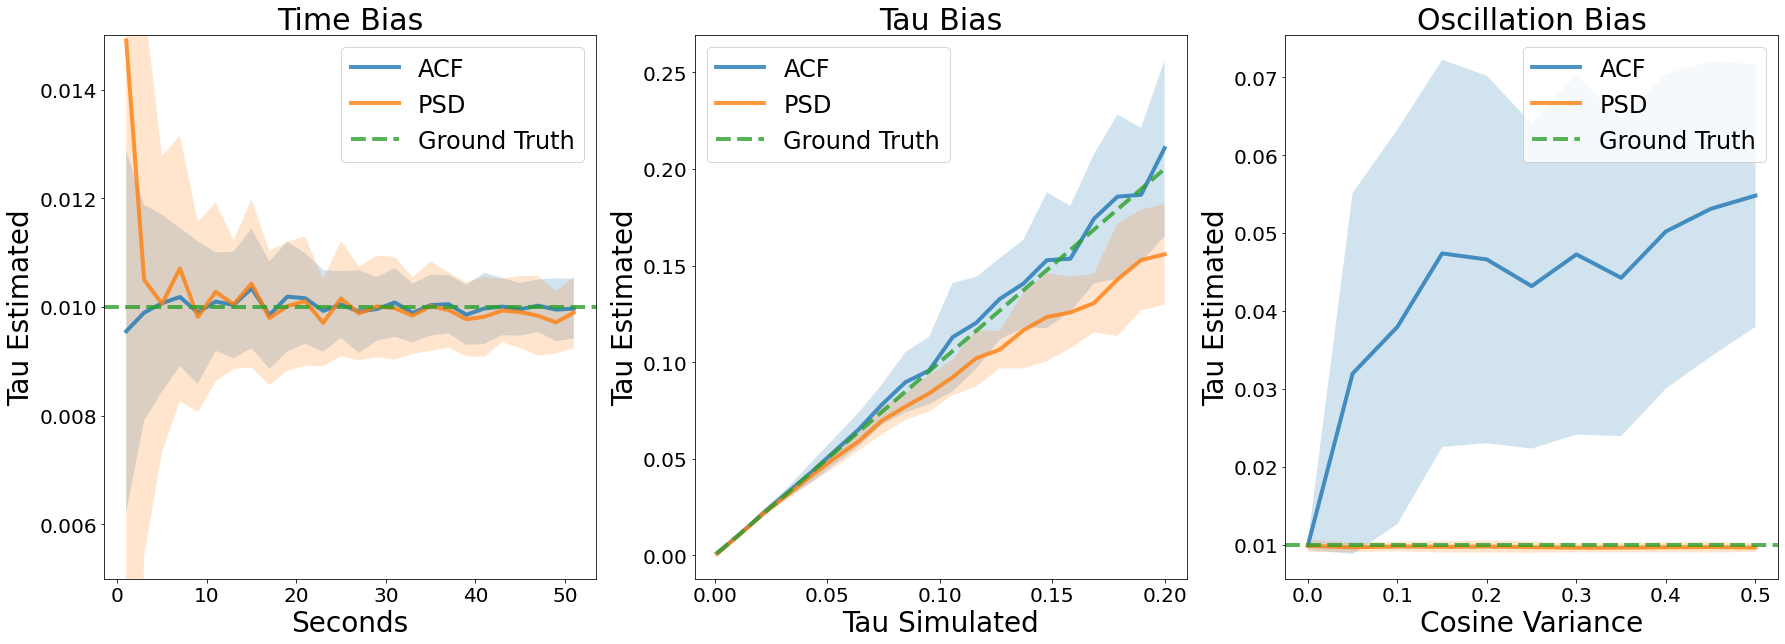

In [4]:
tau = 0.01

fig, axes = plt.subplots(ncols=3, figsize=(30, 10))

plot_param_grid(time_iters['n_seconds'], taus_acf_time, taus_psd_time, tau, 
                'Seconds', 'Tau Estimated', axes[0], mode='mean',
                title='Time Bias', ylim=(.005, 0.015))

plot_param_grid(taus_iters['taus'], taus_acf, taus_psd, None, 
                'Tau Simulated', 'Tau Estimated', axes[1], mode='mean',
                title='Tau Bias')

plot_param_grid(cos_iters['cos_vars'], taus_acf_cos, taus_psd_cos, tau, 
                'Cosine Variance', 'Tau Estimated', axes[2], mode='mean',
                title='Oscillation Bias')

plt.savefig('fig3.png')

### Figure 4

Proposed Workflow